In [1]:
import cufflinks as cf
from plotly.offline import plot, iplot
import pandas as pd
import numpy as np
from pandasql import PandaSQL
import matplotlib.pyplot as plt

In [2]:
cf.go_offline()

In [3]:
# Importando os arquivos
df_employers = pd.read_parquet('gold/employers.parquet')
df_cargos = pd.read_parquet('gold/cargos.parquet')
df_cep = pd.read_parquet('gold/cep.parquet')
df_base_levels = pd.read_parquet('gold/base_levels.parquet')
df_clients = pd.read_parquet('gold/clients.parquet')

In [4]:
df_cargos

,cargo,nivel,area,cod_area,cod_nivel,quadro,bonus,contratacao
0,OPV,Diretor,Operações,JAJ,JE,Efetivo,S,Diretoria
1,LOI,Estagiário,Logísitca,EDE,JA,Efetivo,N,Gerente
2,ADI,Estagiário,Administrativo,BAC,JA,Efetivo,N,Gerente
3,ADII,Analista,Administrativo,BAC,DB,Terceiro,N,RH
4,OPII,Analista,Operações,JAJ,DB,Terceiro,N,RH
5,FIV,Diretor,Financeiro,CBB,JE,Efetivo,S,Diretoria
6,FIII,Analista,Financeiro,CBB,DB,Terceiro,N,RH
7,ADIII,Coordenador,Administrativo,BAC,DB,Terceiro,N,RH
8,LOIV,Gerente,Logísitca,EDE,ID,Efetivo,S,Diretoria
9,FII,Estagiário,Financeiro,CBB,JA,Efetivo,N,Gerente


## VISUALIZAÇÃO E GERAÇÃO DE INSIGHTS

<p>FUNCIONÁRIOS</p>

- Dados de Contratação e Demissão:
	- Taxa de rotatividade.
- Relacionamento com Cargos:
	- Relação entre cargo e nível.

<p> Taxa de rotatividade (%) </p>

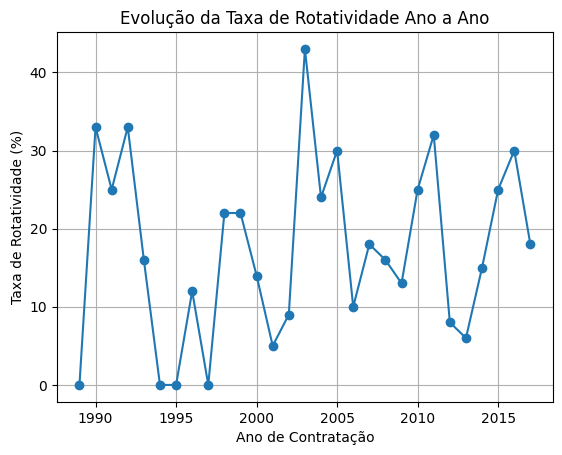

In [5]:
# Adiciona coluna de ano
df_employers['ano_contratacao'] = df_employers['data_de_contratacao'].dt.year

# Inicializa a classe PandaSQL
pysqldf = PandaSQL()

# Calcula a taxa de rotatividade ano a ano usando pandasql
query_rotatividade_ano_a_ano = """
    SELECT 
        ano_contratacao,
        COUNT(DISTINCT id_rh) AS total_funcionarios,
        SUM(CASE WHEN data_de_demissao IS NOT NULL THEN 1 ELSE 0 END) AS funcionarios_que_deixaram,
        100 * SUM(CASE WHEN data_de_demissao IS NOT NULL THEN 1 ELSE 0 END) / COUNT(DISTINCT id_rh) AS taxa_rotatividade
    FROM df_employers
    GROUP BY ano_contratacao
    ORDER BY ano_contratacao
"""

resultado_rotatividade_ano_a_ano = pysqldf(query_rotatividade_ano_a_ano)

# Criar gráfico de linha
plt.plot(resultado_rotatividade_ano_a_ano['ano_contratacao'], resultado_rotatividade_ano_a_ano['taxa_rotatividade'], marker='o')
plt.xlabel('Ano de Contratação')
plt.ylabel('Taxa de Rotatividade (%)')
plt.title('Evolução da Taxa de Rotatividade Ano a Ano')
plt.grid(True)
plt.show()

<p>Distribuição de Funcionários por Cargo e Nível (Ativos)</p>

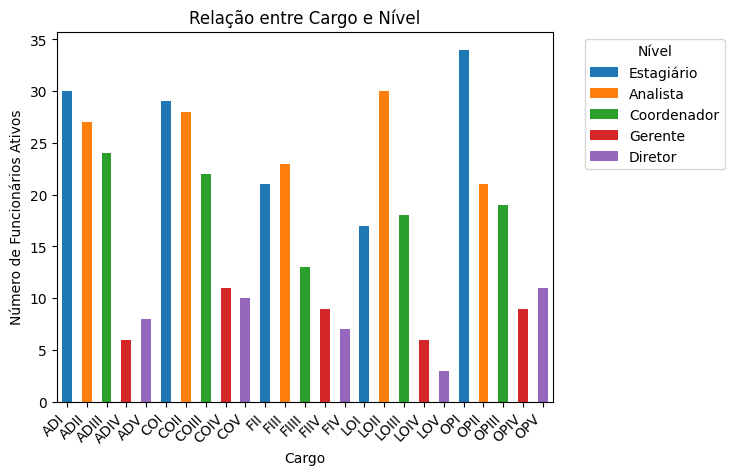

In [6]:
# Calcular a distribuição de funcionários ativos por cargo e nível usando pandasql
dist_func_cargo_nivel_query = """
    SELECT 
        e.cargo as Cargo,
        c.nivel as Nivel,
        COUNT(*) as Quantidade
    FROM df_employers e
    LEFT JOIN df_cargos c ON e.cargo = c.cargo
    WHERE e.data_de_demissao IS NULL
    GROUP BY e.cargo, c.nivel
"""

resultado_dist_func_cargo_nivel = pysqldf(dist_func_cargo_nivel_query)


# Definir a ordem desejada para os níveis
order_niveis = ['Estagiário', 'Analista', 'Coordenador', 'Gerente', 'Diretor']

# Criar gráfico de barras empilhadas
pivot_table = resultado_dist_func_cargo_nivel.pivot_table(index='Cargo', columns='Nivel', values='Quantidade', fill_value=0)

# Reordenar as colunas do DataFrame de acordo com a ordem dos níveis
pivot_table = pivot_table[order_niveis]

# Criar o gráfico de barras empilhadas
ax = pivot_table.plot(kind='bar', stacked=True)

# Obter a ordem atual da legenda
handles, labels = ax.get_legend_handles_labels()

# Reordenar a legenda com base na ordem desejada
order_indices = [labels.index(nivel) for nivel in order_niveis]
ax.legend([handles[i] for i in order_indices], order_niveis, title='Nível', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Cargo')
plt.ylabel('Número de Funcionários Ativos')
plt.title('Relação entre Cargo e Nível')
plt.xticks(rotation=45, ha='right')
plt.show()

### CLIENTES

<p> Contratos e Receitas:</p>
- TOP Valor Contrato Anual
- TOP Quantidade De Serviços
- TOP Nível De Importância


In [7]:
df_clients

,cliente,valor_contrato_anual,quantidade_de_servicos,cargo_responsavel,cep,data_inicio_contrato,nivel_de_importancia
0,Teixeira Gonçalves,54000,37,ADIII,743419711,2019-03-15,3.0
1,Souza Santos,126000,12,FIIV,882467283,2019-04-08,1.0
2,Emídio Alves,319500,23,ADII,295150983,2019-02-09,3.0
3,Santos Costa,252000,64,FIIV,430169311,2019-03-10,2.0
4,Do Monteiro,351000,19,OPV,839424894,2019-01-31,3.0
...,...,...,...,...,...,...,...
320,Manoel Costa,369000,53,LOIV,801388803,2018-11-26,4.0
321,Gomes Machado,238500,45,OPV,131504555,2018-12-04,2.0
322,Alkindar Cardozo,351000,16,FIII,560973100,2018-12-07,1.0
323,Pereira Fazenda,418500,28,FIII,233130568,2019-02-02,1.0


<p>TOP Valor Contrato Anual por Região</p>

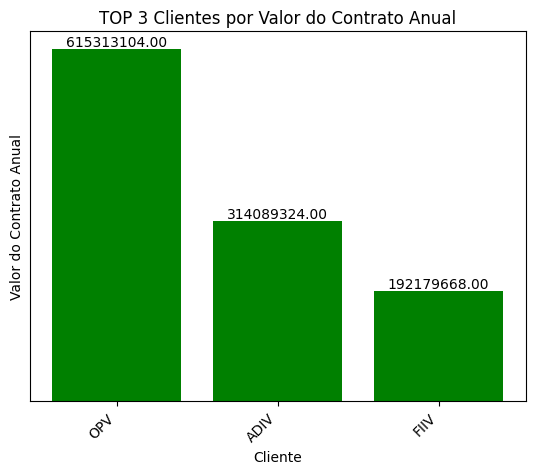

In [8]:
# Consulta SQL para selecionar os TOP 5 clientes pelo valor do contrato anual em ordem decrescente
query_top_clients = """
    SELECT cliente, valor_contrato_anual
    FROM df_clients
    ORDER BY valor_contrato_anual DESC
    LIMIT 3
"""

# Executar a consulta SQL
df_top_clients = pysqldf(query_top_clients)

# Criar gráfico de barras para os TOP clientes
plt.bar(df_top_clients['cliente'], df_top_clients['valor_contrato_anual'],color='green')
plt.xlabel('Cliente')
plt.ylabel('Valor do Contrato Anual')
plt.title('TOP 3 Clientes por Valor do Contrato Anual')
plt.xticks(rotation=45, ha='right')

# Formatar os rótulos do eixo y para exibir valores em formato decimal
plt.ticklabel_format(axis='y', style='plain')

# Adicionar os valores totais em cima das barras
for index, value in enumerate(df_top_clients['valor_contrato_anual']):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Ocultar os rótulos numéricos do eixo y
plt.yticks([])

plt.show()

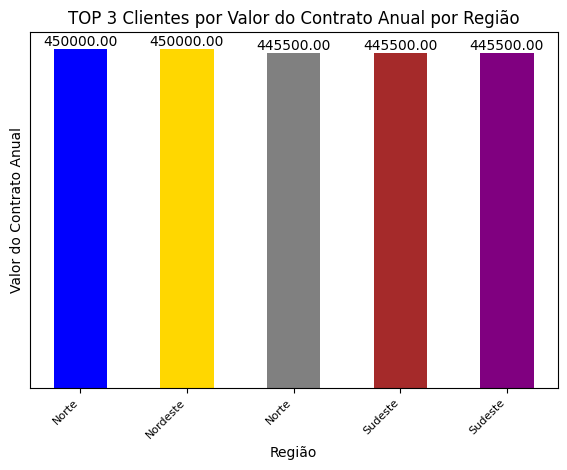

In [9]:
# Consulta SQL para selecionar os TOP clientes por valor do contrato anual por região
query_top_clients = """
    SELECT cli.valor_contrato_anual, reg.regiao
    FROM df_clients AS cli
    INNER JOIN df_cep AS reg
    ON cli.cep = reg.cep
    ORDER BY valor_contrato_anual DESC
    LIMIT 5
"""

# Executar a consulta SQL
df_top_clients = pysqldf(query_top_clients)

# Criar cores diferentes para cada barra
colors = ['blue', '#FFD700', 'gray', 'brown', 'purple']

# Criar gráfico de barras para os TOP clientes por região
bar_width = 0.5  # Ajuste o valor conforme necessário

plt.bar(np.arange(len(df_top_clients['regiao'])), df_top_clients['valor_contrato_anual'], width=bar_width, color=colors)
plt.xlabel('Região')
plt.ylabel('Valor do Contrato Anual')
plt.title('TOP 3 Clientes por Valor do Contrato Anual por Região')
plt.xticks(np.arange(len(df_top_clients['regiao'])), df_top_clients['regiao'], rotation=45, ha='right', fontsize=8)
plt.tight_layout()

# Adicionar os valores totais em cima das barras
for index, value in enumerate(df_top_clients['valor_contrato_anual']):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
plt.yticks([])

plt.show()


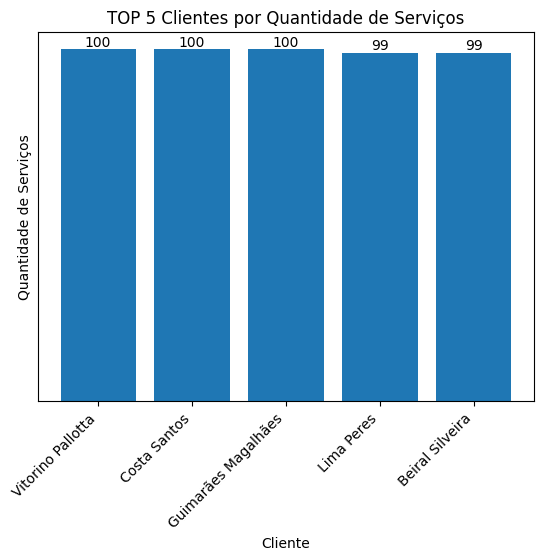

In [10]:
# Consulta SQL para selecionar os TOP 5 clientes pela quantidade de serviços em ordem decrescente
query_top_services = """
    SELECT cliente, quantidade_de_servicos
    FROM df_clients
    ORDER BY quantidade_de_servicos DESC
    LIMIT 5
"""

# Executar a consulta SQL
df_top_services = pysqldf(query_top_services)

# Criar gráfico de barras para os TOP clientes pela quantidade de serviços
plt.bar(df_top_services['cliente'], df_top_services['quantidade_de_servicos'])
plt.xlabel('Cliente')
plt.ylabel('Quantidade de Serviços')
plt.title('TOP 5 Clientes por Quantidade de Serviços')
plt.xticks(rotation=45, ha='right')

# Adicionar os valores totais em cima das barras
for index, value in enumerate(df_top_services['quantidade_de_servicos']):
    plt.text(index, value, f'{value}', ha='center', va='bottom')

# Ocultar os rótulos numéricos do eixo y
plt.yticks([])

plt.show()